
# Classifier ansemble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error

# используем StratifiedKFold чтобы сохранить классовую несимметрию
from sklearn.model_selection import StratifiedKFold

import pickle

import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12, 6)})
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# создаем набор классификаторов
# лейблы
names_class = ["LogisticRegression", "Random Forest (default)", 
           "AdaBoost", "GradientBoosting", "Bagging"]

# stack classifiers
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(max_depth=5),
    AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=1), random_state=42),
    GradientBoostingClassifier(random_state=42), 
    BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=1), random_state=42, n_jobs=-1)]

In [3]:
# функция обучения одной модели
# возвращает mean score при обучении на N фолдах
def cv_estimate(model=None, n_splits=3, train_X=None, train_y=None):
    cv = StratifiedKFold(n_splits=n_splits)
    val_scores = 0
    i = 1
    for train, test in cv.split(train_X, train_y):
        model.fit(train_X.iloc[train], train_y.iloc[train])
        #val_scores += model.score(train_X.iloc[test], train_y.iloc[test])
        val_scores += roc_auc_score(train_y.iloc[test], model.predict_proba(train_X.iloc[test])[:, 1])
        print(i, end=' ')
        i += 1
        
    val_scores /= n_splits
    return val_scores

In [4]:
# читаем данные для обучения (выборка train)
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv').iloc[:, 0]

In [5]:
X = X[['kpca_1', 'kpca_2']]

In [6]:
print(X.shape)
print(y.shape)

(347, 2)
(347,)


In [7]:
y.value_counts()

0    221
1    126
Name: target_freez, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Learning classificators
Обучаем модели с помощью cross validation

In [9]:
def learn_classificators(n_splits=3, train_X=None, train_y=None):
    models_score_class = [[], []]
    for name, clf in zip(names_class, classifiers):
        print(name, end=' ')
        score = cv_estimate(model=clf, n_splits=n_splits, train_X=X_train, train_y=y_train)
        models_score_class[0].append(name)
        models_score_class[1].append(score)
        print()
    return (models_score_class)

In [10]:
%time models_score_class = learn_classificators(5, X_train, y_train)

LogisticRegression 1 2 3 4 5 
Random Forest (default) 1 2 3 4 5 
AdaBoost 1 2 3 4 5 
GradientBoosting 1 2 3 4 5 
Bagging 1 2 3 4 5 
CPU times: user 6.26 s, sys: 118 ms, total: 6.37 s
Wall time: 8.95 s


# Сортируем модели по убыванию roc_auc

In [11]:
models_score_class = pd.DataFrame({'model':pd.Series(models_score_class[0]),
                                   'roc_auc':pd.Series(models_score_class[1])})\
                .sort_values(by='roc_auc', ascending=False)
models_score_class

,model,roc_auc
2,AdaBoost,0.980719
0,LogisticRegression,0.980532
1,Random Forest (default),0.979465
3,GradientBoosting,0.977706
4,Bagging,0.960566


In [12]:
# сохраняем в переменную лучшую модель
best_clf = classifiers[names_class.index(models_score_class.iloc[0, :].model)]

# Выводим таблицу важности фич или силы коэффициентов модели

In [13]:
clf_feature_class = pd.DataFrame()
if 'feature_importances_' in dir(best_clf):
    clf_feature_class = pd.DataFrame({'feature':X_train.columns, 
                                 names_class[classifiers.index(best_clf)]:best_clf.feature_importances_})\
                                .sort_values(by=names_class[classifiers.index(best_clf)], ascending=False)

elif 'coef_' in dir(best_clf):
    clf_feature_class = pd.DataFrame({'feature':X_train.columns, 
                                 names_class[classifiers.index(best_clf)]:best_clf.coef_})\
                                .sort_values(by=names_class[classifiers.index(best_clf)], ascending=False)
elif 'estimators_' in dir(best_clf):
    # усредняем важность фичей для каждого эстиматора в бэггинге
    feature_importances = np.mean([tree.feature_importances_ for tree in best_clf.estimators_], axis=0)
    clf_feature_class = pd.DataFrame({'feature':X_train.columns, 
                                 names_class[classifiers.index(best_clf)]:feature_importances})\
                                .sort_values(by=names_class[classifiers.index(best_clf)], ascending=False)
    
clf_feature_class = clf_feature_class.rename(columns={names_class[classifiers.index(best_clf)]:'importance'})
clf_feature_class['percent'] = clf_feature_class.importance.cumsum().sort_values(ascending=True)
clf_feature_class.head(15)

,feature,importance,percent
0,kpca_1,0.518,0.518
1,kpca_2,0.482,1.000


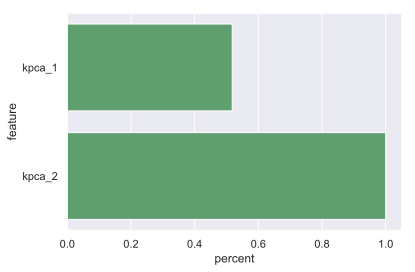

In [14]:
sns.barplot(x='percent', y='feature', data=clf_feature_class[:20], color='g')

# Оценка качества модели
Оцениваем модель на отложенной тестовой выборке

In [14]:
# classifiers
y_pred = best_clf.predict_proba(X_test)[:, 1]

In [15]:
roc_auc_score(y_test, y_pred)

0.9740918803418803

# Сохраняем модель

In [16]:
pickle.dump(best_clf, open('reports/model_clf.sav', 'wb'))